<a href="https://colab.research.google.com/github/olley102/CommunityDetectionURSS/blob/main/autoencoder_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder image segmentation
This is an attempt to implement an idea to use autoencoders to encode local spatial information of images to then apply clustering.

## 1. Sliding window autoencoder

In [1]:
!git clone https://github.com/olley102/CommunityDetectionURSS.git

Cloning into 'CommunityDetectionURSS'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 145 (delta 62), reused 86 (delta 26), pack-reused 0
Receiving objects: 100% (145/145), 2.58 MiB | 10.08 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [2]:
import sys
sys.path.append('/content/CommunityDetectionURSS')

In [3]:
from image_processing import nn

## 2. GPWv411 Population Count dataset

In [4]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 1.2 MB/s 


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!ls '/content/drive/My Drive/GoogleEarthEngine'

GPW_v411_pc_time0.tif  GPW_v411_pc_time2.tif  GPW_v411_pc_time4.tif
GPW_v411_pc_time1.tif  GPW_v411_pc_time3.tif


In [7]:
import rasterio

In [8]:
import numpy as np

In [9]:
with rasterio.open('/content/drive/My Drive/GoogleEarthEngine/GPW_v411_pc_time0.tif', 'r') as ds:
  time0 = ds.read()

gpw = np.zeros((time0.shape[1], time0.shape[2], 5), dtype='float')
gpw[..., 0] = time0[0]

for i in range(4):
  with rasterio.open(f'/content/drive/My Drive/GoogleEarthEngine/GPW_v411_pc_time{i+1}.tif', 'r') as ds:
    gpw[..., i+1] = ds.read()[0]

gpw[np.isnan(gpw)] = 0.0

In [10]:
from image_processing import optical_flow

In [11]:
uv = optical_flow.iteration(gpw, 1, alpha=10, use_previous=True, centering=(0, 0, 0))

In [16]:
image0 = np.dstack((gpw[..., 0], np.moveaxis(uv[..., 0], 0, -1)))

In [17]:
image0.shape

(1796, 1105, 3)

## 3. Apply WindowAE

In [18]:
ae = nn.WindowAE(window_size=(7, 7), num_channels=3, encoder_sizes=(49, 3), decoder_sizes=(49, 245))

In [19]:
ae.make()
ae.compile()

In [20]:
!mkdir /content/checkpoints

In [21]:
fp = '/content/checkpoints/checkpoint_{epoch}.hdf5'
ae.make_callback(fp, period=10)

In [22]:
ae.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 7, 5)]         0         
                                                                 
 flatten (Flatten)           (None, 245)               0         
                                                                 
 dense (Dense)               (None, 49)                12054     
                                                                 
 dense_2 (Dense)             (None, 49)                2450      
                                                                 
 dense_3 (Dense)             (None, 245)               12250     
                                                                 
 reshape (Reshape)           (None, 7, 7, 5)           0         
                                                                 
Total params: 26,754
Trainable params: 26,754
Non-trainable p

In [23]:
ae.encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 7, 5)]         0         
                                                                 
 flatten (Flatten)           (None, 245)               0         
                                                                 
 dense (Dense)               (None, 49)                12054     
                                                                 
 dense_1 (Dense)             (None, 3)                 150       
                                                                 
Total params: 12,204
Trainable params: 12,204
Non-trainable params: 0
_________________________________________________________________


In [24]:
ae.fit_transform(image0)

In [25]:
history = ae.fit(image0, image0, epochs=1500, batch_size=1000)

32/32 [==============================] - 1s 5ms/step - loss: 186945.7500 - mse: 186945.7188
Epoch 2/2
32/32 [==============================] - 0s 4ms/step - loss: 31687.6152 - mse: 31687.6172
Epoch 3/3
32/32 [==============================] - 0s 4ms/step - loss: 10346.7734 - mse: 10346.7725
Epoch 4/4
32/32 [==============================] - 0s 3ms/step - loss: 1178.9089 - mse: 1178.9084
Epoch 5/5
32/32 [==============================] - 0s 3ms/step - loss: 125.6133 - mse: 125.6133
Epoch 6/6
32/32 [==============================] - 0s 3ms/step - loss: 38.7526 - mse: 38.7526
Epoch 7/7
32/32 [==============================] - 0s 4ms/step - loss: 15.3157 - mse: 15.3157
Epoch 8/8
32/32 [==============================] - 0s 4ms/step - loss: 7.2022 - mse: 7.2022
Epoch 9/9
32/32 [==============================] - 0s 4ms/step - loss: 5.1606 - mse: 5.1606
Epoch 10/10
32/32 [==============================] - 0s 5ms/step - loss: 3.4092 - mse: 3.4092
Epoch 11/11
32/32 [=============================

In [26]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'mse')

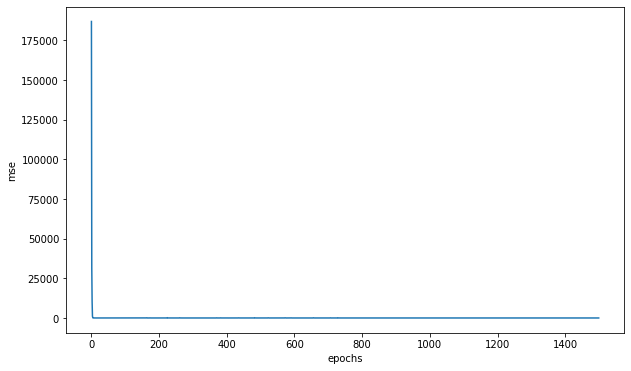

In [34]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()
history_arr = [h.history['loss'][0] for h in history]
ax.plot(history_arr)
ax.set_xlabel('epochs')
ax.set_ylabel('mse')

Learning takes place immediately, but no significant change after the first 10 epochs.

In [31]:
!cp /content/checkpoints/checkpoint_1500.hdf5 /content/drive/My\ Drive/Colab\ Notebooks/Files/checkpoint_1500.hdf5

In [32]:
ae.load_epoch('/content/drive/My Drive/Colab Notebooks/Files/checkpoint_{epoch}.hdf5', 1500)

True

In [46]:
encoding = ae.encode(image0, verbose=True, batch_size=image0.shape[1]*10)

Encoding pixels 0:11050
346/346 [==============================] - 1s 1ms/step
Encoding pixels 11050:22100
346/346 [==============================] - 1s 1ms/step
Encoding pixels 22100:33150
346/346 [==============================] - 1s 1ms/step
Encoding pixels 33150:44200
346/346 [==============================] - 1s 2ms/step
Encoding pixels 44200:55250
346/346 [==============================] - 0s 1ms/step
Encoding pixels 55250:66300
346/346 [==============================] - 0s 1ms/step
Encoding pixels 66300:77350
346/346 [==============================] - 1s 2ms/step
Encoding pixels 77350:88400
346/346 [==============================] - 1s 1ms/step
Encoding pixels 88400:99450
346/346 [==============================] - 1s 2ms/step
Encoding pixels 99450:110500
346/346 [==============================] - 1s 1ms/step
Encoding pixels 110500:121550
346/346 [==============================] - 1s 1ms/step
Encoding pixels 121550:132600
346/346 [==============================] - 1s 2ms/step
Enc

In [33]:
pred = ae.predict(image0, verbose=True, batch_size=image0.shape[1]*100)

Predicting pixels 0:110500
3454/3454 [==============================] - 6s 2ms/step
Predicting pixels 110500:221000
3454/3454 [==============================] - 5s 1ms/step
Predicting pixels 221000:331500
3454/3454 [==============================] - 5s 1ms/step
Predicting pixels 331500:442000
3454/3454 [==============================] - 5s 1ms/step
Predicting pixels 442000:552500
3454/3454 [==============================] - 5s 1ms/step
Predicting pixels 552500:663000
3454/3454 [==============================] - 6s 2ms/step
Predicting pixels 663000:773500
3454/3454 [==============================] - 5s 2ms/step
Predicting pixels 773500:884000
3454/3454 [==============================] - 5s 1ms/step
Predicting pixels 884000:994500
3454/3454 [==============================] - 5s 1ms/step
Predicting pixels 994500:1105000
3454/3454 [==============================] - 5s 2ms/step
Predicting pixels 1105000:1215500
3454/3454 [==============================] - 5s 1ms/step
Predicting pixels 12155

In [35]:
pred.shape

(1796, 1105, 3)

In [23]:
x_full = ae.transform_x(image0)

In [24]:
pred = np.zeros_like(image0)
pad_half = (3, 3)

In [25]:
batch_size = image0.shape[1]*100

In [26]:
ravel_choice = np.arange(0, batch_size)

In [27]:
unravel_choice = np.unravel_index(ravel_choice, image0.shape[:2])

In [28]:
x_stack = np.stack(tuple(x_full[i:i+ae.window_size[0],
                                j:j+ae.window_size[1]]
                         for i, j in np.column_stack(unravel_choice)), axis=0)

In [29]:
p_stack = ae.model.predict(x_stack)

1250/1250 [==============================] - 2s 2ms/step


In [30]:
p_stack[0, pad_half[0], pad_half[1], :-2]

array([-0.31044728,  0.36383826, -0.09009252], dtype=float32)

In [41]:
p_stack[0, :, :, 0]

array([[0.5931405 , 0.8244173 , 0.        , 0.        , 0.        ,
        0.        , 0.99057704],
       [0.5451205 , 0.55352485, 0.39824215, 0.56479895, 0.52607304,
        0.        , 1.0707682 ],
       [0.12811211, 0.44893834, 0.7291636 , 0.4549493 , 0.        ,
        0.9316364 , 0.73696446],
       [0.6261907 , 0.18796426, 0.3754314 , 0.        , 0.47367585,
        0.        , 1.1687497 ],
       [0.5142462 , 0.6220209 , 0.6099675 , 0.5643108 , 0.47716457,
        0.98979944, 0.        ],
       [0.42257786, 0.6835468 , 0.96789706, 0.        , 0.4308476 ,
        0.9807509 , 1.099963  ],
       [0.7770277 , 1.0982451 , 1.0254334 , 1.0509033 , 1.0499032 ,
        1.0958142 , 1.2141967 ]], dtype=float32)

In [38]:
np.any(pred)

True

Text(0.5, 1.0, 'Prediction')

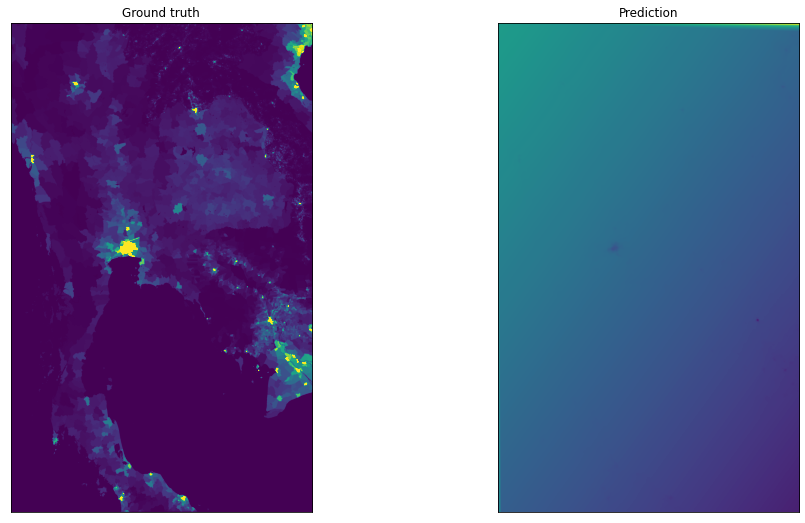

In [43]:
fig = plt.figure(figsize=(16, 9))
ax1 = fig.add_subplot(121)
im1 = ax1.imshow(gpw[..., 0], vmin=0, vmax=1000)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
ax1.set_title('Ground truth')

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(pred[..., 0])
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
ax2.set_title('Prediction')

In [39]:
pred

array([[[ -3493.09810439,   7603.49868742,   8630.92451636],
        [ -1314.30170566,   3198.35270372,   1082.28994477],
        [ -3253.95753582,   3465.21642603,  -1625.21987181],
        ...,
        [-24064.45298009,  69332.93075601, -37844.91324811],
        [-24064.65047053,  69403.61847488, -37874.22845198],
        [-24064.90686163,  69464.75042821, -37904.99884857]],

       [[ -2283.5882544 ,  -3906.95188302,   2178.87868014],
        [ -3043.79305924,  -6273.859226  ,   1897.02972099],
        [ -3560.69527109,  -4845.93057857,     96.41387417],
        ...,
        [-19967.45141797,  66706.59200094, -35996.44083336],
        [-19964.70387552,  66777.3490147 , -36026.94790936],
        [-19962.29934278,  66845.68763674, -36055.27566103]],

       [[ -4374.6278701 ,  -6094.84800029,   2485.96418915],
        [ -4608.68998931,  -7792.67678556,   1912.04397507],
        [ -3556.13610032,  -5711.40645028,   -135.89443464],
        ...,
        [-15837.40831918,  64033.93654035,

In [47]:
np.any(encoding)

True

In [48]:
encoding.shape

(1796, 1105, 3)

In [49]:
np.max(encoding)

2704.52392578125

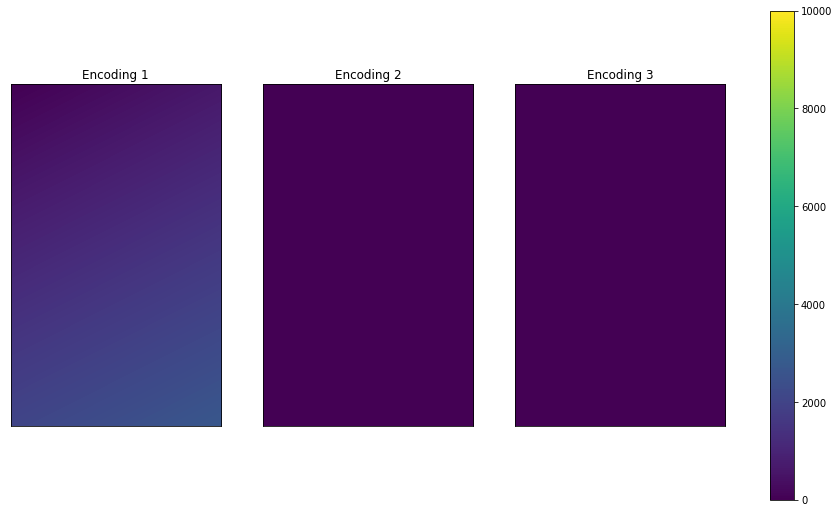

In [50]:
fig = plt.figure(figsize=(16, 9))
axes = []

for i in range(3):
  ax = fig.add_subplot(1, 3, i+1)
  im = ax.imshow(encoding[..., i], vmin=0, vmax=10000)
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)
  ax.set_title(f'Encoding {i+1}')
  axes.append(ax)

fig.colorbar(im, ax=axes)

In [44]:
ae.max  # PROBLEM: we need to use different values of max and min for each channel of the image
# also this is way too big so we need to use a threshold for the image before use

58110.33203125

In [45]:
ae.min

-18.436128723608686